In [1]:
import sys
import os

sys.path.append(os.path.abspath("../Classifiers"))

from RF import * 

In [2]:
import warnings
warnings.filterwarnings( 'ignore' )
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  f1_score, precision_score, recall_score


In [3]:
feature_type = "noGeographic"

In [4]:
if not os.path.isdir("Results"):
    os.mkdir("Results")
if not os.path.isdir(f"Results/{feature_type}"):
    os.mkdir(f"Results/{feature_type}")

### Paths to top30 from GTD data

In [5]:
trains = ['train100', 'train200', 'train300', 'train478']
tests = ['test100', 'test200', 'test300', 'test478', ]
traindir = f'../../../../data/top30groups/{feature_type}/train1'
testdir = f'../../../../data/top30groups/{feature_type}/test1'

trainpaths = []
testpaths = []
for i, partition in enumerate(trains):
    trainpaths.append(f'{traindir}/{partition}.csv')
    testpaths.append(f'{testdir}/{tests[i]}.csv')

### Training models and computing accuracy

In [6]:
models = []
accuracies = []
predictions = []
truths = []
probas = []
n = [100, 200, 300, 478]
train_times = []
for i, path in enumerate(trainpaths):
    print(f'Computing for partition {i+1}, balanced classes with {n[i]} entries for each class')

    # run classifier on data
    rfc, accuracy, y_pred_rfc, labels, proba, train_time = main(trainpaths[i], testpaths[i])

    #  saving models, accuracies, predictions, and truths in case we need it for statistics later
    models.append(rfc)
    accuracies.append(accuracy)
    predictions.append(y_pred_rfc)
    truths.append(labels)
    probas.append(proba)
    train_times.append(train_time)

    print("---------------------------------------------------")

Computing for partition 1, balanced classes with 100 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Training best RF classifier...
Making predictions...
Accuracy: 48.56%
---------------------------------------------------
Computing for partition 2, balanced classes with 200 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 52.78%
---------------------------------------------------
Computing for partition 3, balanced classes with 300 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 54.11%
---------------------------------------------------
Computing for partition 4, balanced classes with 478 entries for each class
Finding optimal hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training best RF classifier...
Making predictions...
Accuracy: 54.79%
------------------------------------------------

In [7]:
for i in range(len(truths)):
    print(f'Classification report size {n[i]}')
    print(classification_report(predictions[i], truths[i]))
    print('--------------------------------------')

Classification report size 100
                                                  precision    recall  f1-score   support

                          Abu Sayyaf Group (ASG)       0.37      0.46      0.41        24
        African National Congress (South Africa)       0.80      0.43      0.56        56
                                Al-Qaida in Iraq       0.53      0.44      0.48        36
        Al-Qaida in the Arabian Peninsula (AQAP)       0.33      0.30      0.32        33
                                      Al-Shabaab       0.30      0.41      0.35        22
             Basque Fatherland and Freedom (ETA)       0.43      0.59      0.50        22
                                      Boko Haram       0.30      0.39      0.34        23
  Communist Party of India - Maoist (CPI-Maoist)       0.63      0.53      0.58        36
       Corsican National Liberation Front (FLNC)       0.87      0.53      0.66        49
                       Donetsk People's Republic       0.53      0.5

In [8]:
from sklearn.metrics import roc_auc_score

with open(f"Results/{feature_type}/rf_top30_{feature_type}.txt", "w") as f:
    for i in range(len(trainpaths)):
        f.write(f"Partition {i+1} - {n[i]} samples per class, with longitude and latitude data\n")
        f.write(f"Accuracy: {accuracies[i]*100:.2f}%\n")
        f.write(f"Precision Score weighted: {precision_score(truths[i], predictions[i], average='weighted')}\n")
        f.write(f"recall Score weighted: {recall_score(truths[i], predictions[i], average='weighted')}\n")
        f.write(f"f1 Score weighted: {f1_score(truths[i], predictions[i], average='weighted')}\n")
        f.write(f"Precision Score micro: {precision_score(truths[i], predictions[i], average='micro')}\n")
        f.write(f"recall Score micro: {recall_score(truths[i], predictions[i], average='micro')}\n")
        f.write(f"f1 Score micro: {f1_score(truths[i], predictions[i], average='micro')}\n")
        f.write(f"Precision Score macro: {precision_score(truths[i], predictions[i], average='macro')}\n")
        f.write(f"recall Score macro: {recall_score(truths[i], predictions[i], average='macro')}\n")
        f.write(f"f1 Score macro: {f1_score(truths[i], predictions[i], average='macro')}\n")
        f.write(f"roc auc weighted: {roc_auc_score(truths[i], probas[i],multi_class='ovr', average='weighted'):.4f}\n")
        f.write(f"roc auc macro: {roc_auc_score(truths[i], probas[i], multi_class='ovr', average='macro'):.4f}\n")
        f.write(f"roc auc micro: {roc_auc_score(truths[i], probas[i], multi_class='ovr', average='micro'):.4f}\n")
        f.write("---------------------------------------------------\n")

for partition in n:
    with open(f"Results/{feature_type}/traintimes_gtd{partition}.txt", "w") as f:
        f.write(str(train_times[i]))


In [9]:
def plot_confusion_matrix(y_true, y_pred, labels, partition_id):
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_normalized,
                annot=True,
                fmt=".2f",
                xticklabels=labels,
                yticklabels=labels,
                cmap="viridis",
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})

    plt.title(f"Normalized Confusion Matrix (Partition {partition_id})", fontsize=18)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the figure
    save_path = f"Results/{feature_type}/confusion_matrix_partition_{partition_id}.png"
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"Saved confusion matrix for partition {partition_id} to {save_path}")


In [10]:
for i in range(len(truths)):
    y_true = truths[i]
    y_pred = predictions[i]

    # Get all unique class labels from the truths
    class_labels = np.unique(np.concatenate(truths))

    plot_confusion_matrix(y_true, y_pred, labels=class_labels, partition_id=i + 1)

# Combined
all_true = np.concatenate(truths)
all_pred = np.concatenate(predictions)
all_labels = np.unique(all_true)

plot_confusion_matrix(all_true, all_pred, labels=all_labels, partition_id="All")


Saved confusion matrix for partition 1 to Results/noGeographic/confusion_matrix_partition_1.png
Saved confusion matrix for partition 2 to Results/noGeographic/confusion_matrix_partition_2.png
Saved confusion matrix for partition 3 to Results/noGeographic/confusion_matrix_partition_3.png
Saved confusion matrix for partition 4 to Results/noGeographic/confusion_matrix_partition_4.png
Saved confusion matrix for partition All to Results/noGeographic/confusion_matrix_partition_All.png


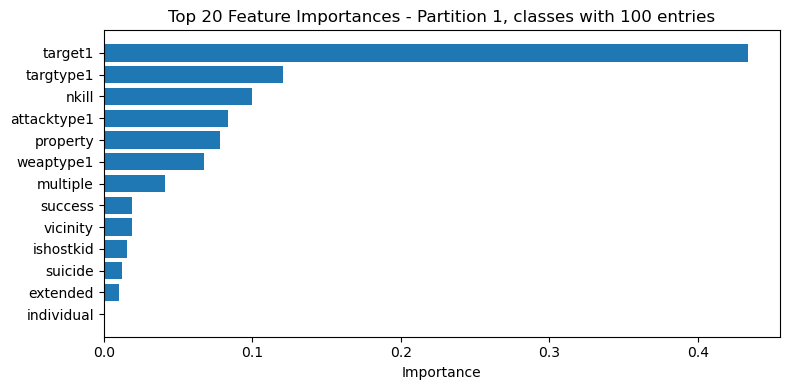

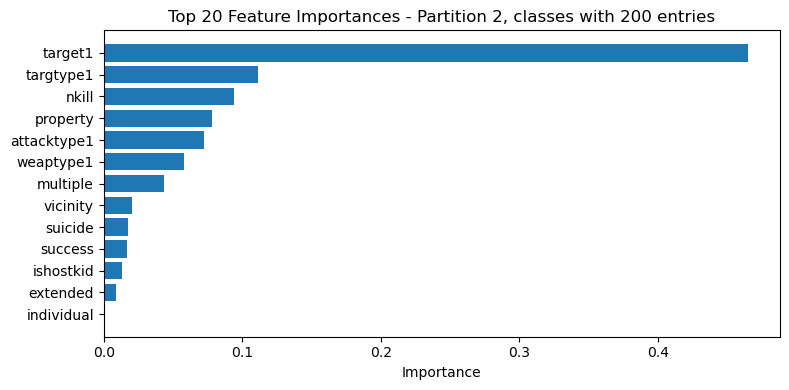

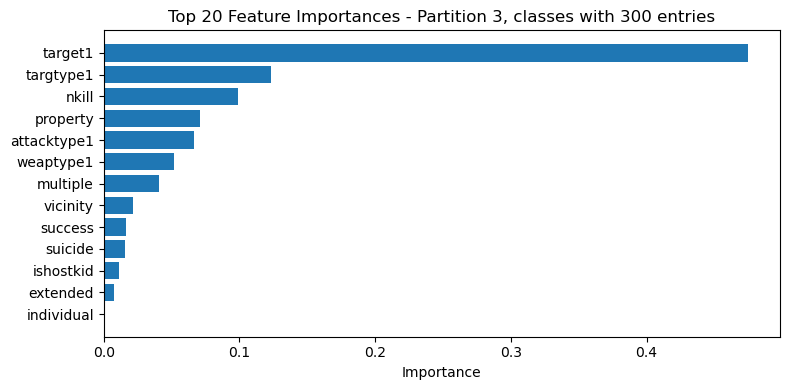

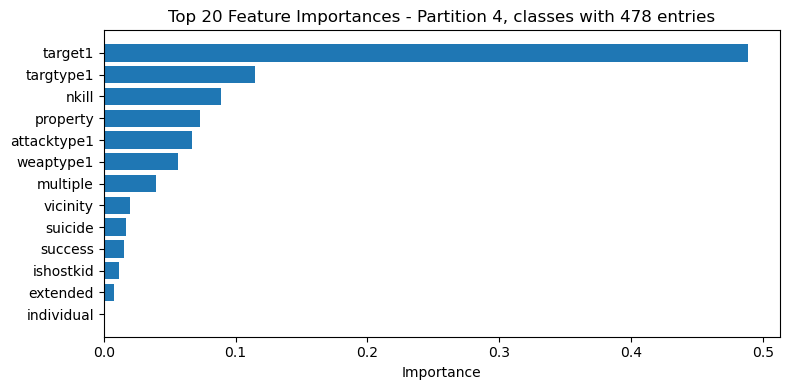

In [11]:
top_k = 20

for i, rfc in enumerate(models):
    importances = rfc.feature_importances_

    feature_names = rfc.feature_names_in_

    indices = np.argsort(importances)[::-1][:top_k]
    top_features = [feature_names[j] for j in indices]
    top_importances = importances[indices]

    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_importances[::-1])
    plt.xlabel("Importance")
    plt.title(f"Top {top_k} Feature Importances - Partition {i+1}, classes with {n[i]} entries")
    plt.tight_layout()
    plt.show()